In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report as report


### Apply sepsis label to lab and text data

In [2]:
noteevents = pd.read_csv("noteevents_full_icustays.csv") #all text for all patients
patients = pd.read_csv("combined_patients_no_text.csv") #all patient data except for text, including presumed sepsis onset

In [3]:
patients.columns

Index(['Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj'],
      dtype='object')

In [4]:
sorted(np.unique(patients["m:presumed_onset"]))

[0.0,
 4116096000.0,
 4116282420.0,
 4116681600.0,
 4117651200.0,
 4118256000.0,
 4118817600.0,
 4118860800.0,
 4119292800.0,
 4119874140.0,
 4120451520.0,
 4120934400.0,
 4121193600.0,
 4121366400.0,
 4121412300.0,
 4121613240.0,
 4122219300.0,
 4122394740.0,
 4122489600.0,
 4122582480.0,
 4122706140.0,
 4122748800.0,
 4122796560.0,
 4122798180.0,
 4122802800.0,
 4122976500.0,
 4123353600.0,
 4123364880.0,
 4123414800.0,
 4123910160.0,
 4124030400.0,
 4124102880.0,
 4124104980.0,
 4124173860.0,
 4124625000.0,
 4124822400.0,
 4124908800.0,
 4125029040.0,
 4125305100.0,
 4125427200.0,
 4125499980.0,
 4125686400.0,
 4125772800.0,
 4125816360.0,
 4125826800.0,
 4125829080.0,
 4125859200.0,
 4126118400.0,
 4126550400.0,
 4126803300.0,
 4126807560.0,
 4126930740.0,
 4127047500.0,
 4127234400.0,
 4127328000.0,
 4127673600.0,
 4128105600.0,
 4128364800.0,
 4128796800.0,
 4128969600.0,
 4129184700.0,
 4129315200.0,
 4129360980.0,
 4129656180.0,
 4129660800.0,
 4130265600.0,
 4130784000.0,
 413

In [8]:
patients["sepsis_label"] = np.where(patients["m:presumed_onset"] > 0.0, 1, 0)

In [14]:
patients["sepsis_label"].value_counts()

sepsis_label
0    1102706
1     889233
Name: count, dtype: int64

In [24]:
ids = np.unique(patients["m:icustayid"]).astype("int")
ids

array([200003, 200006, 200007, ..., 299993, 299995, 299999])

In [40]:
x = []
y = []
i = 0
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(patients["sepsis_label"].loc[patients["m:icustayid"] == id]).astype("int")
    x.append(id)
    y.append(label.item())
lookup = pd.DataFrame({"icustayid": x,
                       "label": y})

100%|██████████| 43388/43388 [01:17<00:00, 560.17it/s]


In [48]:
lookup["label"].loc[lookup["icustayid"]==200003].item()

1

In [49]:
for id in tqdm(ids):
    label = lookup["label"].loc[lookup["icustayid"]==id].item()
    noteevents.loc[noteevents["icustay_id"] == id, "sepsis_label"] = label

100%|██████████| 43388/43388 [02:23<00:00, 302.72it/s]


In [50]:
patients.to_csv("patients_no_text_sepsis_labels.csv")

In [1]:
noteevents.to_csv("noteevents_full_icustays_sepsis_labels.csv")

NameError: name 'noteevents' is not defined

### Begin here to load labeled data

In [2]:
lab = pd.read_csv("patients_no_text_sepsis_labels.csv")
text = pd.read_csv("noteevents_full_icustays_sepsis_labels.csv")

In [3]:
lab.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'a:action', 'm:charttime', 'm:icustayid',
       'm:presumed_onset', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:DiaBP', 'o:FiO2_1', 'o:GCS', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb',
       'o:INR', 'o:Magnesium', 'o:MeanBP', 'o:PT', 'o:PTT', 'o:PaO2_FiO2',
       'o:Platelets_count', 'o:Potassium', 'o:RR', 'o:SGOT', 'o:SGPT',
       'o:SIRS', 'o:SOFA', 'o:Shock_Index', 'o:Sodium', 'o:SpO2', 'o:SysBP',
       'o:Temp_C', 'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age',
       'o:cumulated_balance', 'o:gender', 'o:input_4hourly', 'o:input_total',
       'o:max_dose_vaso', 'o:mechvent', 'o:output_4hourly', 'o:output_total',
       'o:paCO2', 'o:paO2', 'o:re_admission', 'r:reward', 'step', 'traj',
       'sepsis_label'],
      dtype='object')

### evaluate feature importance for lab values

In [4]:
print(lab.step.value_counts(bins=5, normalize=True))

step
(-0.079, 15.6]    0.340063
(15.6, 31.2]      0.290511
(31.2, 46.8]      0.187400
(46.8, 62.4]      0.121931
(62.4, 78.0]      0.060095
Name: proportion, dtype: float64


In [3]:
min_step = 12
data = lab.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'a:action','m:presumed_onset','r:reward'])
ids = data["m:icustayid"].loc[data["step"] == min_step]
df_ = data.loc[data["m:icustayid"].isin(ids)]

In [5]:
# 30016 patients with at least 31 steps
print(len(ids), len(np.unique(df_["m:icustayid"])))

41871 41871


In [4]:
df_.isna().sum()


m:charttime                  0
m:icustayid                  0
o:Arterial_BE                0
o:Arterial_lactate           0
o:Arterial_pH                0
o:BUN                        0
o:Calcium                    0
o:Chloride                   0
o:Creatinine                 0
o:DiaBP                      0
o:FiO2_1                     0
o:GCS                        0
o:Glucose                    0
o:HCO3                       0
o:HR                         0
o:Hb                         0
o:INR                        0
o:Magnesium                  0
o:MeanBP                     0
o:PT                         0
o:PTT                        0
o:PaO2_FiO2             885027
o:Platelets_count            0
o:Potassium                  0
o:RR                         0
o:SGOT                       0
o:SGPT                       0
o:SIRS                       0
o:SOFA                       0
o:Shock_Index                0
o:Sodium                     0
o:SpO2                       0
o:SysBP 

In [5]:
from collections import Counter
#make groundtruth for the selected patients
ground_truth = []
for id in tqdm(ids):
    # get the label for each icustayid and create lookup
    label = np.unique(df_["sepsis_label"].loc[df_["m:icustayid"] == id]).astype("int")
    ground_truth.append(label.item())
#drop empty features, as well as SOFA and SIRS as they are processed from other lab features
df = df_.drop(columns=["o:output_4hourly", "o:output_total", "o:SOFA", "o:SIRS", "step", "traj", "sepsis_label", "o:input_4hourly", "o:input_total", "o:PaO2_FiO2", "o:GCS", "o:PTT", "o:DiaBP", "o:MeanBP", "o:SpO2", "o:cumulated_balance"])
#occurences of septic and non septic in selected patients
Counter(ground_truth).items()

100%|██████████| 41871/41871 [01:10<00:00, 593.55it/s]


dict_items([(1, 18043), (0, 23828)])

In [6]:
df.columns

Index(['m:charttime', 'm:icustayid', 'o:Arterial_BE', 'o:Arterial_lactate',
       'o:Arterial_pH', 'o:BUN', 'o:Calcium', 'o:Chloride', 'o:Creatinine',
       'o:FiO2_1', 'o:Glucose', 'o:HCO3', 'o:HR', 'o:Hb', 'o:INR',
       'o:Magnesium', 'o:PT', 'o:Platelets_count', 'o:Potassium', 'o:RR',
       'o:SGOT', 'o:SGPT', 'o:Shock_Index', 'o:Sodium', 'o:SysBP', 'o:Temp_C',
       'o:Total_bili', 'o:WBC_count', 'o:Weight_kg', 'o:age', 'o:gender',
       'o:max_dose_vaso', 'o:mechvent', 'o:paCO2', 'o:paO2', 'o:re_admission'],
      dtype='object')

In [7]:
cols = list(df.columns)
temp2 = []
for id in tqdm(ids):
    #grab data of one patient
    df_raw = df.loc[df["m:icustayid"] == id] 
    #drop icustayid to avoid learning the id to label correspondence
    d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
    #flatten all features and corresponding values of all timesteps into single sequence, used for classifier, feature importance etc
    temp2.append(list(d.values.flatten()))
df_raw = df.loc[df["m:icustayid"] == id] 
d = df_raw.drop(columns=["m:icustayid", "m:charttime"])
cols = list(d.columns)


100%|██████████| 41871/41871 [01:31<00:00, 459.47it/s]


In [8]:
cols

['o:Arterial_BE',
 'o:Arterial_lactate',
 'o:Arterial_pH',
 'o:BUN',
 'o:Calcium',
 'o:Chloride',
 'o:Creatinine',
 'o:FiO2_1',
 'o:Glucose',
 'o:HCO3',
 'o:HR',
 'o:Hb',
 'o:INR',
 'o:Magnesium',
 'o:PT',
 'o:Platelets_count',
 'o:Potassium',
 'o:RR',
 'o:SGOT',
 'o:SGPT',
 'o:Shock_Index',
 'o:Sodium',
 'o:SysBP',
 'o:Temp_C',
 'o:Total_bili',
 'o:WBC_count',
 'o:Weight_kg',
 'o:age',
 'o:gender',
 'o:max_dose_vaso',
 'o:mechvent',
 'o:paCO2',
 'o:paO2',
 'o:re_admission']

In [9]:
# trim data to equal length for classification
thresh = min_step*(len(cols)) #-1 since we remove icustayids afterwards, length of data * number of features = one patient for prediction/training
#cutoff = list(filter(lambda i: len(i) >= thresh, temp2))
#ground_truth_cutoff = [ground_truth["sepsis_label"][x] for x, i in enumerate(datalist) if len(i) >= thresh]

preprocessed_data = [element[:thresh] for element in temp2] # should be shape [#ofpatients, minstep*#offeatures]
print(f"shape of preprocessed data: [{len(preprocessed_data)}, {len(preprocessed_data[0])}]")
print(f"number of patients: {len(temp2)}")
print(f"length of ground truth: {len(ground_truth)}")
print(f"length of desired patient data: {thresh}")



shape of preprocessed data: [41871, 408]
number of patients: 41871
length of ground truth: 41871
length of desired patient data: 408


In [10]:
df_data = pd.DataFrame(preprocessed_data)
df_data

,0,1,2,3,4,5,6,7,8,9,...,398,399,400,401,402,403,404,405,406,407
0,1.071661,-0.560359,1.069870,-0.380498,0.094949,-0.115152,-0.151959,0.270372,-0.431229,1.257526,...,1.695768,0.298152,-0.165619,-0.963438,-0.5,-2.302585,-0.5,0.342991,2.502016,-0.5
1,1.071661,-0.807791,-1.359161,1.099965,0.094949,-0.275503,0.872138,-0.829653,-0.336055,1.456557,...,-0.481630,-0.524785,0.772330,1.187623,0.5,-2.302585,0.5,3.034376,-1.125315,0.5
2,-1.013271,2.161392,-1.359161,0.110697,-0.775842,1.167654,-0.867791,-0.279641,-0.488332,-0.135694,...,-0.886884,0.272831,-0.450723,1.217268,-0.5,-2.302585,0.5,-0.464425,0.110725,-0.5
3,-0.086635,0.016982,0.195419,0.521029,1.090139,0.045199,0.339249,-0.499646,-0.577161,-0.732788,...,-0.481630,0.095583,1.276426,-0.610490,-0.5,-2.302585,-0.5,-1.182127,-0.600200,-0.5
4,1.998297,0.264414,0.584064,0.521029,3.702513,-0.115152,0.339249,-1.324664,-0.355090,-0.732788,...,0.434184,-0.828638,-0.401139,0.164828,-0.5,-2.302585,-0.5,0.881268,0.498502,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41866,0.498824,-0.291916,-0.257693,0.798865,0.910616,-0.704312,1.605759,0.109145,-0.684329,-0.644026,...,0.857872,-0.282480,0.254079,-0.456686,-0.5,-2.302585,-0.5,0.892817,-0.381476,-0.5
41867,-0.537904,1.065483,-0.547534,0.471950,0.231097,0.191409,-0.228448,-0.340459,0.055309,-0.175933,...,-0.891924,1.762800,0.164370,0.122087,-0.5,-1.123930,-0.5,-1.229844,-0.385573,-0.5
41868,-1.185859,1.668771,-0.040313,0.242901,0.367001,0.728841,-0.316105,-0.340459,0.872804,-0.644026,...,0.025693,-0.793800,1.608256,-0.160118,-0.5,-2.302585,-0.5,-0.391262,-0.246279,-0.5
41869,-0.969874,-0.518149,0.853363,0.207179,1.726039,-1.600032,-0.316105,-0.115657,0.872804,-0.175933,...,-0.355152,0.182357,-1.616993,-2.147015,-0.5,-2.302585,-0.5,0.132852,-0.008660,-0.5


In [11]:
duplicates = df_data.duplicated()
duplicates.value_counts()

False    41871
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_data, ground_truth, test_size=0.30, random_state=100,stratify=ground_truth)

In [13]:
print(f"Shape of X_train: {len(X_train)}")
print(f"Shape of X_test: {len(X_test)}")
print("Class Balance in Training Data:", Counter(y_train).items())
print("Class Balance in Test Data:", Counter(y_test).items())


Shape of X_train: 29309
Shape of X_test: 12562
Class Balance in Training Data: dict_items([(0, 16679), (1, 12630)])
Class Balance in Test Data: dict_items([(0, 7149), (1, 5413)])


In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239
15602,-0.019540,-0.895205,0.321988,1.108495,1.726039,-0.704312,0.010399,-0.051725,-0.115657,0.509088,...,-0.205007,-0.399515,0.004282,0.044881,-0.5,-2.302585,-0.5,0.342498,-0.459317,-0.5
26115,3.090643,-0.291916,-2.576419,-0.113414,0.367001,-1.241744,-1.101423,0.005009,1.233155,0.509088,...,-0.499403,0.198544,-0.314251,0.155233,-0.5,-2.302585,0.5,2.229308,-0.729711,-0.5
28289,-0.019540,0.235961,0.177068,1.495359,0.706760,-0.346024,0.346567,0.051221,-0.565261,0.509088,...,-0.406436,-0.489224,0.053700,0.557029,-0.5,-2.302585,-0.5,-0.391262,1.826743,-0.5
2732,2.461615,0.016982,-0.096065,1.488530,1.338937,-1.558309,3.390630,0.231259,-0.554647,-0.528819,...,-0.752675,-0.190411,-0.182240,-0.071659,-0.5,-2.302585,-0.5,0.432704,1.597203,-0.5
16301,0.239642,1.442538,-0.112773,-0.683553,0.095193,-0.346024,-0.346353,0.080046,-0.565261,0.509088,...,-0.065556,0.493302,0.064651,-0.990462,-0.5,-2.302585,-0.5,2.963067,0.163409,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25806,-1.833814,0.085139,-1.417056,1.331551,1.861943,1.624561,0.776050,-0.040745,-0.958665,0.509088,...,-0.437425,-1.740877,0.677939,0.262188,-0.5,-2.302585,-0.5,0.132852,-0.869005,-0.5
5929,1.303320,1.336619,0.292580,0.278644,1.338937,0.205549,0.229982,-0.309597,0.270372,0.683362,...,-1.005886,0.445907,0.447915,-0.286436,-0.5,-2.302585,-0.5,-0.284999,-0.947584,-0.5
21707,-0.019540,0.311372,0.321988,0.055291,-0.448422,-0.346024,0.346567,-0.059046,-0.340459,0.509088,...,-0.762811,0.108836,1.609353,0.984949,-0.5,-2.302585,-0.5,-1.753958,-0.672355,-0.5
6081,-0.086635,-0.395404,0.681225,-1.638764,1.214538,-2.680765,-1.111927,0.631492,-1.324664,0.683362,...,1.994668,-1.153151,-1.497129,0.127287,0.5,-2.302585,-0.5,-1.002702,0.676233,-0.5


In [14]:
clf = make_pipeline(StandardScaler(),HistGradientBoostingClassifier(class_weight="balanced", l2_regularization=0.01, verbose=1))

In [15]:
clf.fit(X_train, y_train)

Binning 0.086 GB of training data: 0.836 s
Binning 0.010 GB of validation data: 0.008 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.62302, val loss: 0.62413, in 0.083s
[2/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.56202, val loss: 0.56407, in 0.084s
[3/100] 1 tree, 31 leaves, max depth = 20, train loss: 0.51380, val loss: 0.51661, in 0.084s
[4/100] 1 tree, 31 leaves, max depth = 20, train loss: 0.47162, val loss: 0.47519, in 0.087s
[5/100] 1 tree, 31 leaves, max depth = 19, train loss: 0.43049, val loss: 0.43404, in 0.082s
[6/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.39460, val loss: 0.39866, in 0.085s
[7/100] 1 tree, 31 leaves, max depth = 18, train loss: 0.36340, val loss: 0.36772, in 0.085s
[8/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.33205, val loss: 0.33634, in 0.080s
[9/100] 1 tree, 31 leaves, max depth = 17, train loss: 0.30878, val loss: 0.31301, in 0.083s
[10/100] 1 tree, 31 leaves, max depth = 19

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                l2_regularization=0.01,
                                                verbose=1))])

In [16]:
print("Score:", clf.score(X_test, y_test))
pr = clf.predict(X_test)
print(report(y_true=y_test, y_pred=pr))

Score: 1.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7149
           1       1.00      1.00      1.00      5413

    accuracy                           1.00     12562
   macro avg       1.00      1.00      1.00     12562
weighted avg       1.00      1.00      1.00     12562



In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [18]:
print("Score:", forest.score(X_test, y_test))
pr_forest = forest.predict(X_test)
print(report(y_true=y_test, y_pred=pr_forest))

Score: 0.9831237064161757
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7149
           1       0.98      0.98      0.98      5413

    accuracy                           0.98     12562
   macro avg       0.98      0.98      0.98     12562
weighted avg       0.98      0.98      0.98     12562



### Data good enough to learn, maybe too good??
#### Use feature importance to find most relevant features -> Those are the ones we want to learn to predict.

In [19]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_names = cols*min_step
len(feature_names)


408

In [20]:
forest_importances = pd.DataFrame(importances, index=feature_names)

In [21]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [22]:
df

,0
o:Arterial_BE,0.057686
o:Arterial_lactate,0.006993
o:Arterial_pH,0.016104
o:BUN,0.006444
o:Calcium,0.005686
o:Chloride,0.005813
o:Creatinine,0.017026
o:FiO2_1,0.158755
o:Glucose,0.006924
o:HCO3,0.007553


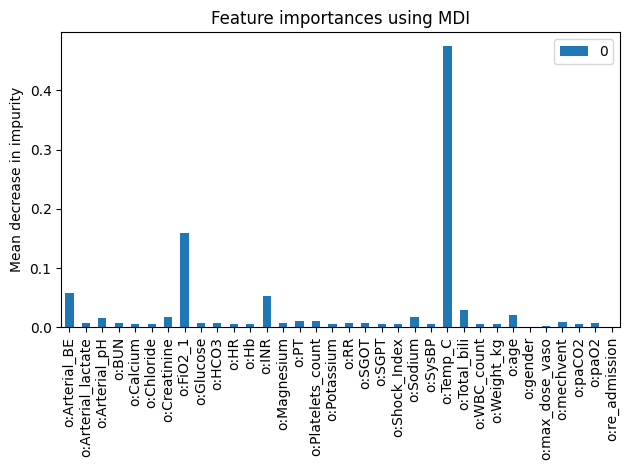

In [23]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [46]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)



In [59]:
forest_importances = pd.DataFrame(result.importances_mean, index=feature_names)
forest_importances

,0
o:Arterial_BE,0.0
o:Arterial_lactate,0.0
o:Arterial_pH,0.0
o:BUN,0.0
o:Calcium,0.0
...,...
o:max_dose_vaso,0.0
o:mechvent,0.0
o:paCO2,0.0
o:paO2,0.0


In [60]:
df = pd.pivot_table(forest_importances, index=forest_importances.index,aggfunc='sum')

In [76]:
df.columns

RangeIndex(start=0, stop=1, step=1)

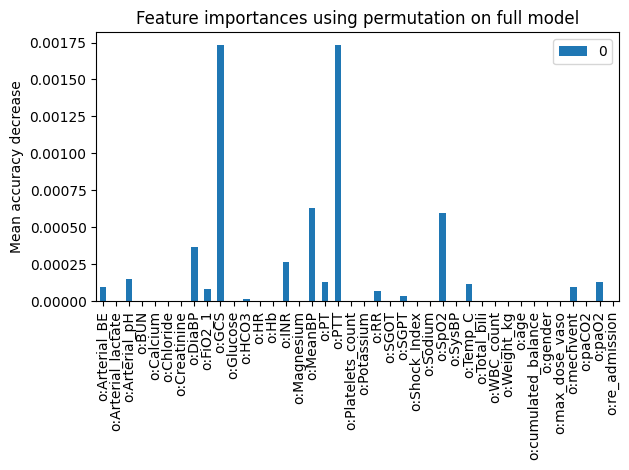

In [63]:
fig, ax = plt.subplots()
df.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### apply tfidf to text, and evaluate feature importance